Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

Using N_types_stage as id variables

U

,tf,Gene,x,OSN,trend_class,g_cluster
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
1,ARID3A,BCL11B,44,Y,trans_up,3
2,ARID3A,RTN2,49,Y,NA,NA
3,ARID3A,PTPN1,44,Y,NA,NA


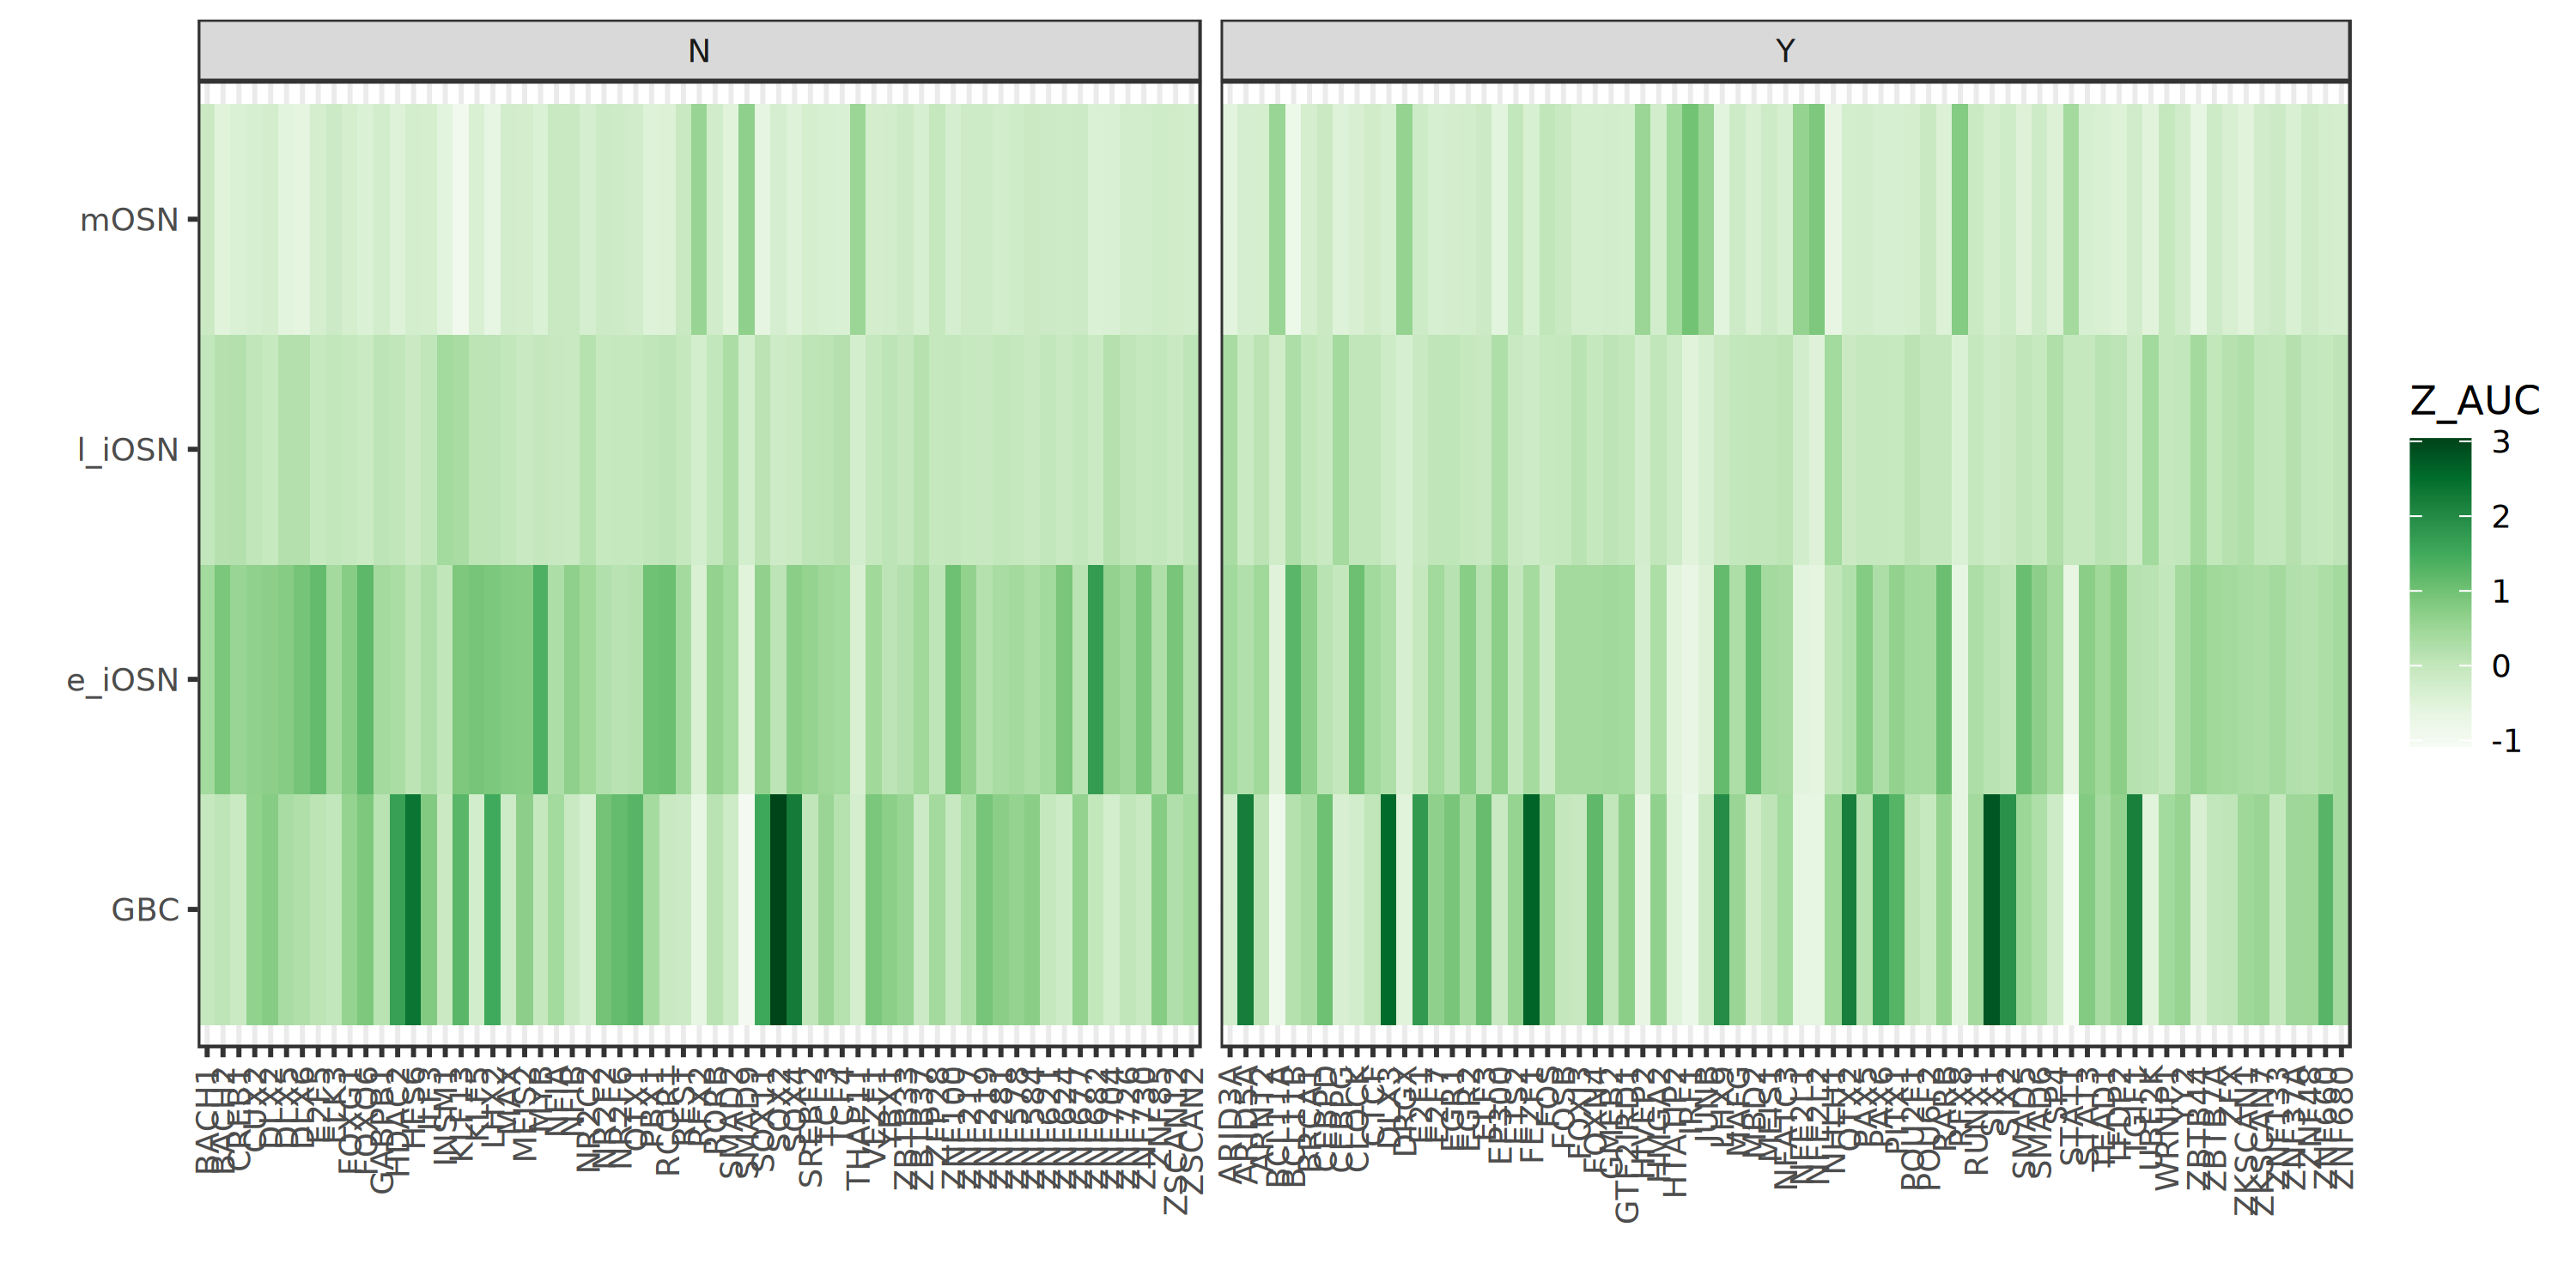

In [93]:
library(reshape2)
library(RColorBrewer)
library(ggplot2)
library(stringr)
library(ComplexHeatmap)

setwd('/sc/arion/projects/roussp01a/liting/Olf/data/scenic_tf_auc')

tf_auc <- list()
for (repi in list.files(path = '/sc/arion/projects/roussp01a/liting/Olf/data/scenic_tf_auc', pattern = '^tf_aucscore_re*')){
  tf_auc[[repi]]=melt(read.csv(repi))
}
dev_files <- list.files('/sc/arion/projects/roussp01a/liting/Olf/data/lister_devDEG/', '.txt')
dev_gs <- c()
for(fl in dev_files){
  dev_g <- read.table(paste0('/sc/arion/projects/roussp01a/liting/Olf/data/lister_devDEG/',fl),header = T)
  cell_type <- gsub('\\.txt|-','',fl)
  dev_g$celltype <- cell_type
  dev_gs <- rbind(dev_g, dev_gs)
}

#dev_gs <- subset(dev_gs, !grepl('^MT|^LINC|^MIR|^RP',gene_name ) & celltype=='L23_CUX2')
dev_gs <- subset(dev_gs, !grepl('^MT|^LINC|^MIR|^RP',gene_name ) )
down_brain <- subset(dev_gs, trend_class=='down')[,'gene_name']
#down_brain <- subset(dev_gs)[,'gene_name']

tf_aucs <- do.call('rbind',tf_auc)
xx=as.data.frame(sort(table(tf_aucs$variable))/4)
tf_aucs <- subset(tf_aucs, variable %in%subset(xx, Freq >= 30)[,'Var1'])
tf_aucs_mean <-  aggregate(value~N_types_stage+variable, tf_aucs, mean )
tf_aucs_mean$OSN <- ifelse(tf_aucs_mean$variable%in%c(down_brain),'N','Y')
options(repr.plot.width=10, repr.plot.height=5)

yy = subset(tf_aucs_mean,  value> 0.4)[,'variable']
myPalette = colorRampPalette(brewer.pal(9, 'Greens'), space='Lab')
tf_aucs_mean$variable <- as.character(tf_aucs_mean$variable)
sub_tf_aucs_mean <- subset(tf_aucs_mean,variable%in%yy)
ggplot(sub_tf_aucs_mean,aes(x=variable, y=factor(N_types_stage, levels = c('GBC','e_iOSN','l_iOSN','mOSN'))))+
  geom_tile(aes(fill = value))+
  scale_fill_gradientn(colours = myPalette(100),name = 'Z_AUC')+
  theme_bw()+
  facet_grid(.~OSN,scales = 'free',space = 'free')+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
  ylab('')+xlab('')

#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/tf.pdf',width=7,height=4)

setwd('/sc/arion/projects/roussp01a/liting/Olf/data/scenic_tf_auc')

tf_targets <- list()
for (repi in list.files(path = '/sc/arion/projects/roussp01a/liting/Olf/data/scenic_tf_auc', pattern = '^entnn_allG_tf_target*')){
  tf_targets[[repi]]=unique(read.csv(repi)[,c(2,4)])
}

#down_brain <- subset(dev_gs, trend_class=='down')[,'gene_name']
tf_targets <- do.call('rbind',tf_targets)
tf_targets$x <- 1

tf_targets_rep <- aggregate(x~tf+ X0,tf_targets, length )
tf_targets_rep_s <- subset(tf_targets_rep, x >= 40  )
tf_targets_rep_s <- subset(tf_targets_rep_s, tf!=X0)
selected_tf_byNtargets <- names(which(table(tf_targets_rep_s$tf) >= 10))
tf_targets_rep_s <- subset(tf_targets_rep_s,tf%in% selected_tf_byNtargets)

load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')#DEG_trend_Olf

sub_tf <- unique(sub_tf_aucs_mean[,c('variable','OSN')])
sub_tf_targets_rep_s <- merge(tf_targets_rep_s, sub_tf, by.x='tf', by.y='variable')
colnames(sub_tf_targets_rep_s)[2] <- 'Gene'
sub_tf_targets_rep_s$trend_class <- DEG_trend_Olf[sub_tf_targets_rep_s$Gene,'trend_class']
sub_tf_targets_rep_s$g_cluster <- DEG_trend_Olf[sub_tf_targets_rep_s$Gene,'g_cluster']

sub_tf_targets_rep_s[1:3,]
save(sub_tf_targets_rep_s, file='/sc/arion/projects/roussp01a/liting/Olf/data/sub_tf_targets_rep_s.RData')


load('/sc/arion/projects/roussp01a/liting/Olf/data/disease_genes.RData')
load('/sc/arion/projects/roussp01a/liting/Olf/data/DEG_trend_Olf_k7_graph.RData')
load('/sc/arion/projects/roussp01a/liting/Olf/data/custom_olfbg.RData')


# 要检查的基因
disresult <- list()

for (gene in unique(sub_tf_targets_rep_s$Gene)){
  # 检查基因属于哪些集合
  result <- sapply(disease_gene_list, function(x) gene %in% subset(x,score >= 0.7)$gene_symbol)
  # 显示结果
  result_sets <- paste(names(result[result == TRUE]), collapse = ", ")
  disresult[[gene]] <- result_sets
}
disresult <- unlist(disresult)

sub_tf_targets_rep_s$disease <- disresult[sub_tf_targets_rep_s$Gene]


#save(disease_gene_list, file='./data/disease_genes.RData')



hyper_test <- function(bg_genes, geneset_A, geneset_B) {
  geneset_B <- intersect(geneset_B, bg_genes)
  n_overlap <- length(intersect(geneset_A, geneset_B))
  
  # 超几何分布检验
  p_value <- phyper(n_overlap - 1, length(geneset_B), 
                    length(bg_genes) - length(geneset_B), 
                    length(geneset_A), 
                    lower.tail = FALSE)
  
  return(p_value)
}

fisher <- function(BG, geneset_A, geneset_B) {
  geneset_B <- intersect(geneset_B, BG)
  aa <- length(intersect(geneset_B, geneset_A))
  bb <- length(setdiff(geneset_B, geneset_A))
  cc <- length(setdiff(geneset_A, geneset_B))
  dd <- length(setdiff(BG, c(geneset_B, geneset_A)))
  
  # Fisher精确检验
  test <- fisher.test(matrix(c(aa, bb, cc, dd), nrow = 2),alternative = 'greater')
  
  return(test$p.value)
}

fisher_OR <- function(BG, geneset_A, geneset_B) {
  geneset_B <- intersect(geneset_B, BG)
  aa <- length(intersect(geneset_B, geneset_A))
  bb <- length(setdiff(geneset_B, geneset_A))
  cc <- length(setdiff(geneset_A, geneset_B))
  dd <- length(setdiff(BG, c(geneset_B, geneset_A)))
  
  # Fisher精确检验
  test <- fisher.test(matrix(c(aa, bb, cc, dd), nrow = 2),alternative = 'greater')
  
  return(test$estimate[[1]])
}


## trend _enriched_results
trend_enriched_results <- data.frame(TF = character(), trend = character(), hyper_p = numeric(), fisher_p = numeric(), fisher_OR = numeric(),stringsAsFactors = FALSE)

for (TF in unique(sub_tf_targets_rep_s$tf)) {
  
  geneset_A <- subset(sub_tf_targets_rep_s, tf == TF)[, 'Gene']
  
  for (trend in unique(DEG_trend_Olf$trend_class)) {
    geneset_B <- subset(DEG_trend_Olf, trend_class == trend)[, 'gene']
    
    hp <- hyper_test(bg_genes = custom_olfbg, geneset_A, geneset_B)
    fsp <- fisher(custom_olfbg, geneset_A, geneset_B)
    fsor <- fisher_OR(custom_olfbg, geneset_A, geneset_B)
    
    trend_enriched_results <- rbind(trend_enriched_results, data.frame(TF = TF, trend = trend, 
                                         hyper_p = hp, fisher_p = fsp, fisher_OR= fsor))
  }
}


## cluster _enriched_results
cluster_enriched_results <- data.frame(TF = character(), trend = character(), hyper_p = numeric(), fisher_p = numeric(),  fisher_OR = numeric(),
                                     stringsAsFactors = FALSE)

for (TF in unique(sub_tf_targets_rep_s$tf)) {
  geneset_A <- subset(sub_tf_targets_rep_s, tf == TF)[, 'Gene']
  
  for (trend in unique(DEG_trend_Olf$g_cluster)) {
    geneset_B <- subset(DEG_trend_Olf, g_cluster == trend)[, 'gene']
    
    hp <- hyper_test(bg_genes = custom_olfbg, geneset_A, geneset_B)
    fsp <- fisher(custom_olfbg, geneset_A, geneset_B)
    fsor <- fisher_OR(custom_olfbg, geneset_A, geneset_B)
    
    cluster_enriched_results <- rbind(cluster_enriched_results, data.frame(TF = TF, trend = trend, 
                                                                       hyper_p = hp, fisher_p = fsp, fisher_OR= fsor))
  }
}


## disease enriched results
disease_enriched_results <- data.frame(TF = character(), trend = character(), hyper_p = numeric(), fisher_p = numeric(), fisher_OR = numeric(),
                                       stringsAsFactors = FALSE)

for (TF in unique(sub_tf_targets_rep_s$tf)) {
  geneset_A <- subset(sub_tf_targets_rep_s, tf == TF)[, 'Gene']
  
  for (trend in names(disease_gene_list)) {
    geneset_B <- subset(disease_gene_list[[trend]])[, 'gene_symbol']
    
    hp <- hyper_test(bg_genes = custom_olfbg, geneset_A, geneset_B)
    fsp <- fisher(custom_olfbg, geneset_A, geneset_B)
    fsor <- fisher_OR(custom_olfbg, geneset_A, geneset_B)
    
    disease_enriched_results <- rbind(disease_enriched_results, data.frame(TF = TF, trend = trend, 
                                                                           hyper_p = hp, fisher_p = fsp, fisher_OR= fsor))
  }
}



library(circlize)

get_heatmap_input <- function(cate){
  
  if(cate=="disease"){trend_enriched_results = disease_enriched_results}
  if(cate=="trend"){trend_enriched_results = trend_enriched_results}
  if(cate=="cluster"){trend_enriched_results = cluster_enriched_results}
  
  trend_enriched_results$fisher_p <- p.adjust( trend_enriched_results$fisher_p, 'fdr')
  
  target_gene <- dcast(data =trend_enriched_results[,c(1,2,5)], formula = TF~ trend)
  rownames(target_gene) <- target_gene$TF
  target_gene <- target_gene[,-1]
  target_gene[target_gene==Inf] <- 10
  
  
  target_p <- dcast(data =trend_enriched_results[,c(1,2,4)], formula = TF~ trend)
  rownames(target_p) <- target_p$TF
  target_p <- target_p[,-1]
  target_p <- ifelse(target_p < 0.05, '+','')
  
  max_d <- max(target_gene)
  min_d <- min(target_gene)
  
  return(list(OR=target_gene, P=target_p, max_d=max_d, min_d=min_d ))
  
}

make_heatmap <- function(categ){
  
  heatmap_input <- get_heatmap_input(categ)
  p1 <- Heatmap(heatmap_input$OR ,  
                #col=colorRamp2(c(0.00, 0.25 ,0.50 ,0.75 ,1,2.5,5,7.5,10), #brewer.pal(n = 11, name = "PiYG")[c(3:9)]
                #               c(rev(brewer.pal(n = 9, name = "Oranges")[2:5]), brewer.pal(n = 9, name = "YlGn")[1:5]))  ,
                #col=colorRamp2(rev(seq(-3,3,length=6)), brewer.pal(n = 11, name = "RdGy")[3:8]),
                #col=colorRamp2(rev(seq(-3,3,length=3)),c('#FCB461',"grey",'white')),
                col=colorRamp2(seq(0,10,length=8),c('white',brewer.pal(n = 9, name = "Reds")[1:7])),
                cluster_columns = F,
                show_heatmap_legend=F,
                cell_fun = function(j, i, x, y, width, height, fill) {
                  grid.text(heatmap_input$P[i, j], x, y, gp = gpar(fontsize = 7))},
                column_names_gp=gpar(fontsize = 9),
                column_title = stringr::str_to_title(categ),
                column_title_gp = gpar(fill = "lightgray", fontsize = 9, col = "black", border = "lightgray"),
                rect_gp = gpar(col = "gray", lwd = 0.15),show_column_dend = F, show_row_dend = F )
  
  lgd1  <- Legend(col_fun = colorRamp2(seq(0,10,length=8),c('white',brewer.pal(n = 9, name = "Reds")[1:7])),
                  title = "OR",
                  direction = "horizontal")
  return(list(p=p1, lgd=lgd1))
}

In [94]:
library(tidyverse)

tf_aucsore_mean <- tf_aucs_mean %>%
  pivot_wider(
    names_from = N_types_stage ,   # 将 variable 列中的值作为新列名
    values_from =    value   # 将 value 列的值填充到新列中
  )

colnames(tf_aucsore_mean)[1:2] <- c('TF','OSN-specific')
tf_aucsore_mean$`OSN-specific` <- ifelse(tf_aucsore_mean$`OSN-specific`=='Y','OSN-specific','shared')
tf_aucsore_mean[1:3,]
#write.table(tf_aucsore_mean,file='/sc/arion/projects/roussp01a/liting/Olf/figures/TF_aucell.txt',sep='\t',quote = F , row.names=F)


TF,OSN-specific,e_iOSN,GBC,l_iOSN,mOSN
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
AHR,OSN-specific,0.3130675,-0.4202562,-0.07154077,0.0581492
ARID3A,OSN-specific,0.4473519,-0.2361789,0.35495621,-0.5397240
ARID5A,OSN-specific,0.2247747,2.2339116,-0.10900581,-0.3126132


In [117]:
options(repr.plot.width = 8, repr.plot.height = 9, repr.plot.res = 300)

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using fisher_OR as value column: use value.var to override.

Using fisher_p as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using BETA as value column: use value.var to override.

Using fdr as value column: use value.var to override.

Using P as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using BETA as value column: use value.var to override.

Using fdr as value column: use value.var to override.

Using P as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using BETA as value column: use value.var to override.

Using fdr as value column: use value.var to override.

Using P as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, co

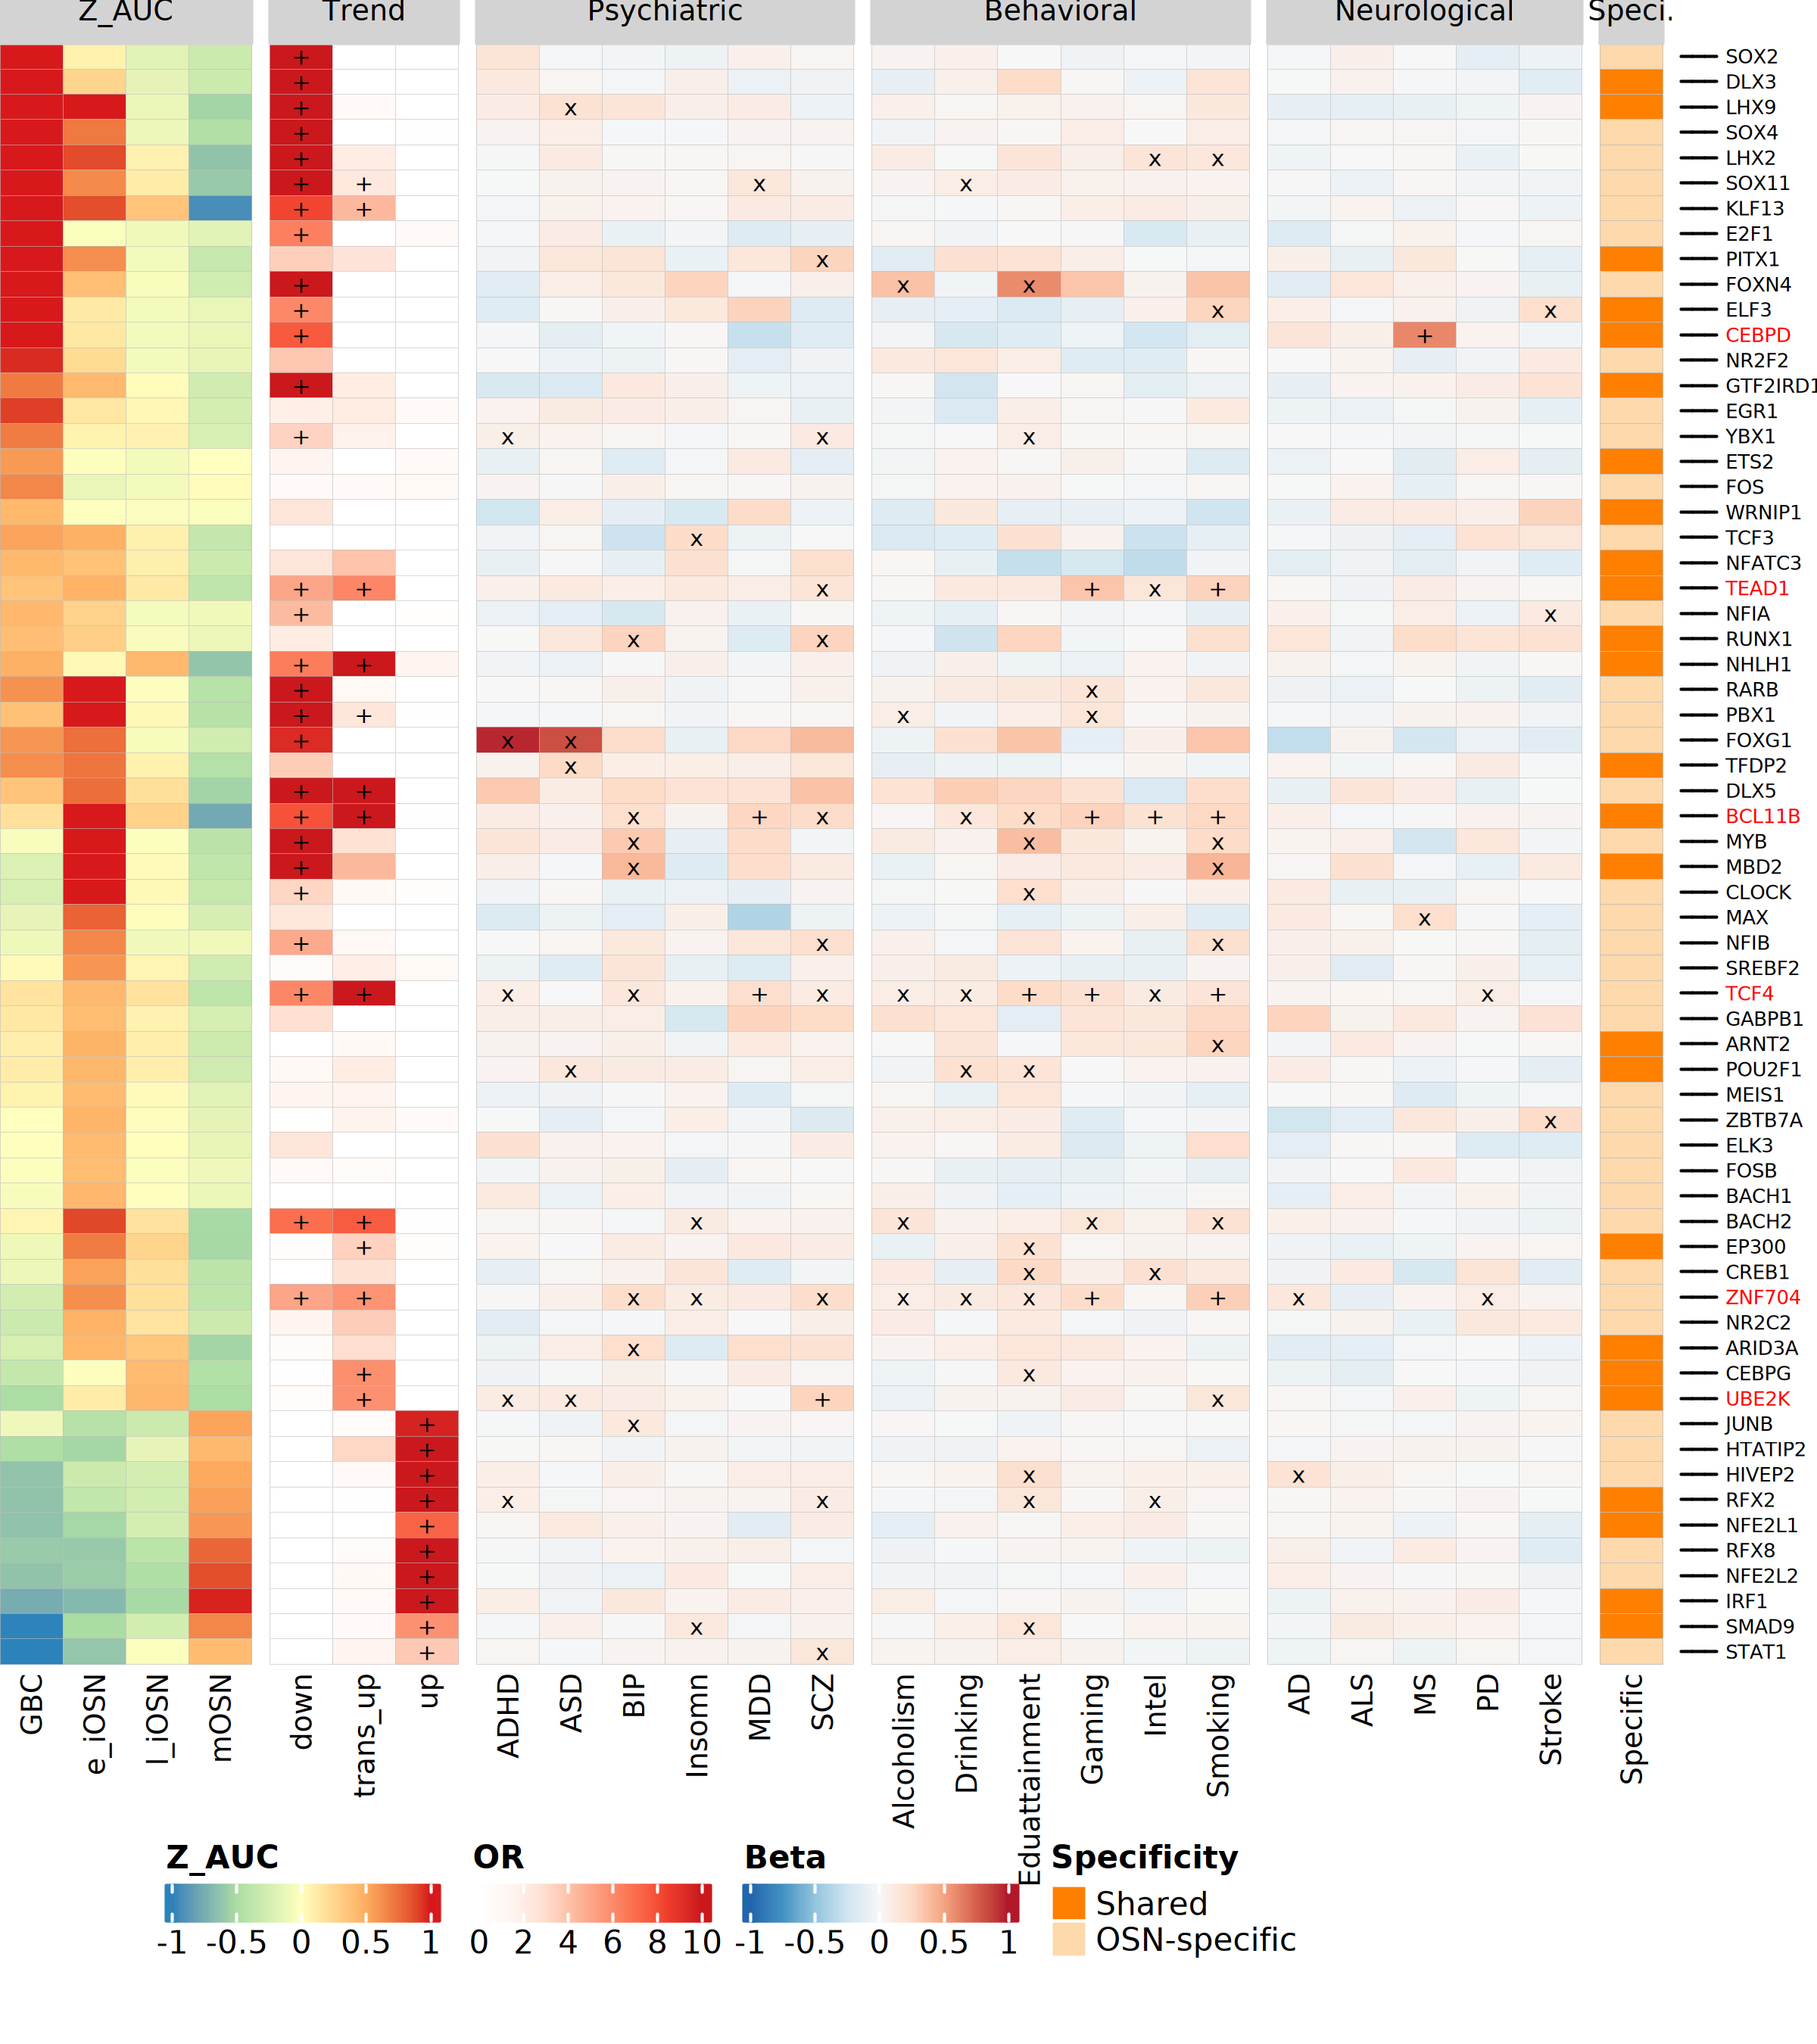

In [124]:
load('/sc/arion/projects/roussp01a/liting/Olf/data/magma_TF_tragets_allTF.RData')

#load('/sc/arion/projects/roussp01a/liting/Olf/data/magma_TF_tragets.RData')#geneSetGroupAgg_rs_sig from 03b_run_magma_tf.R
geneSetGroupAgg_rs_sig$gwasAcronym <-  str_split(geneSetGroupAgg_rs_sig$gwasAcronym,'_',simplify = T)[,1]

geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs_sig,name%in%c(sub_tf_targets_rep_s$tf) )

geneSetGroupAgg_rs_sig$gwasAcronym <- gsub('\\d','',geneSetGroupAgg_rs_sig$gwasAcronym)
geneSetGroupAgg_rs_sig$gwasAcronym <- str_split(geneSetGroupAgg_rs_sig$gwasAcronym,'_',simplify = T)[,1]
geneSetGroupAgg_rs_sig$gwasAcronym <- ifelse(geneSetGroupAgg_rs_sig$gwasAcronym%in%c('als','asd','adhd','bip','mdd','scz','als','pd','ms'),toupper(geneSetGroupAgg_rs_sig$gwasAcronym) ,str_to_title(geneSetGroupAgg_rs_sig$gwasAcronym) )
geneSetGroupAgg_rs_sig$gwasAcronym[geneSetGroupAgg_rs_sig$gwasAcronym=='Alzbellenguez'] <- 'AD'

geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs_sig,name%in%c(sub_tf_targets_rep_s$tf) & gwasAcronym!='Bdandsczshared' )


# TF TARGETS MAGMA
get_heatmap_input_tf <- function(cate){
  
  geneSetGroupAgg_rs_sig <- subset(geneSetGroupAgg_rs_sig, category==cate)

 # geneSetGroupAgg_rs_sig$fdr <- p.adjust( geneSetGroupAgg_rs_sig$P, 'BH')
  geneSetGroupAgg_rs_sig$fdr <-   p.adjust( geneSetGroupAgg_rs_sig$P, 'fdr')
  
  target_gene <- dcast(data =geneSetGroupAgg_rs_sig[,c('name','gwasAcronym','BETA')], formula = name~ gwasAcronym)
  rownames(target_gene) <- target_gene$name
  target_gene <- target_gene[,-1]

  
  target_fdr <- dcast(data =geneSetGroupAgg_rs_sig[,c('name','gwasAcronym','fdr')], formula = name~ gwasAcronym)
  rownames(target_fdr) <- target_fdr$name
  target_fdr <- target_fdr[,-1]
  
  target_p <- dcast(data =geneSetGroupAgg_rs_sig[,c('name','gwasAcronym','P')], formula = name~ gwasAcronym)
  rownames(target_p) <- target_p$name
  target_p <- target_p[,-1]
  
  
  target_p <- ifelse(target_fdr < 0.05,'+',ifelse(target_p < 0.05, 'x',''))
  
  #max_d <- max(target_gene)
  #min_d <- min(target_gene)
  
  return(list(OR=target_gene, P=target_p ))
  
}
make_heatmap_tf <- function(categ){
  
  heatmap_input <- get_heatmap_input_tf(categ)
  p1 <- Heatmap(heatmap_input$OR ,  
                #col=colorRamp2(c(0.00, 0.25 ,0.50 ,0.75 ,1,2.5,5,7.5,10), #brewer.pal(n = 11, name = "PiYG")[c(3:9)]
                #               c(rev(brewer.pal(n = 9, name = "Oranges")[2:5]), brewer.pal(n = 9, name = "YlGn")[1:5]))  ,
                #col=colorRamp2(rev(seq(-3,3,length=6)), brewer.pal(n = 11, name = "RdGy")[3:8]),
                #col=colorRamp2(rev(seq(-3,3,length=3)),c('#FCB461',"grey",'white')),
                col=colorRamp2(seq(-1,1,length=9) ,  rev(brewer.pal(n = 9, name = "RdBu"))),
                cluster_columns = F,
                show_heatmap_legend=F,
                cell_fun = function(j, i, x, y, width, height, fill) {
                  grid.text(heatmap_input$P[i, j], x, y, gp = gpar(fontsize = 7))},
                column_names_gp=gpar(fontsize = 9),
                column_title = stringr::str_to_title(categ),
                column_title_gp = gpar(fill = "lightgray", fontsize = 9, col = "black", border = "lightgray"),
                rect_gp = gpar(col = "gray", lwd = 0.15),show_column_dend = F, show_row_dend = F )
  
  lgd1  <- Legend(col_fun = colorRamp2(seq(-1,1,length=9) ,  rev(brewer.pal(n = 9, name = "RdBu"))),
                  title = "Beta",
                  direction = "horizontal")
  return(list(p=p1, lgd=lgd1))
}


# TF activity in cell types

zscore_tf_aucs <- dcast(data =sub_tf_aucs_mean[,c(1,2,3)], formula = variable~ N_types_stage)
rownames(zscore_tf_aucs) <- zscore_tf_aucs$variable
zscore_tf_aucs <- zscore_tf_aucs[unique(sub_tf_targets_rep_s$tf),-1]

zscore_tf_aucs$maxzscore <- colnames(zscore_tf_aucs)[apply(zscore_tf_aucs, 1,  which.max)]
tfs <- read.table('/sc/arion/projects/roussp01a/liting/Olf/data/INP_TF.txt',sep='\t',header = T)

zscore_tf_aucs <- within(zscore_tf_aucs,{
  OSN <- ''
  OSN[maxzscore=='GBC'] <- ifelse(rownames(zscore_tf_aucs)[maxzscore=='GBC'] %in% c(subset(dev_gs, trend_class%in%c('down'))[,'gene_name'],tfs$Gene.Name),'Shared', 'OSN-specific')
  OSN[maxzscore==c('e_iOSN')] <- ifelse(rownames(zscore_tf_aucs)[maxzscore=='e_iOSN'] %in% c(subset(dev_gs, trend_class%in%c('down','trans_up'))[,'gene_name'],tfs$Gene.Name),'Shared', 'OSN-specific')
  OSN[maxzscore=='l_iOSN'] <- ifelse(rownames(zscore_tf_aucs)[maxzscore=='l_iOSN'] %in% subset(dev_gs, trend_class=='trans_up')[,'gene_name'],'Shared', 'OSN-specific')
  OSN[maxzscore=='mOSN'] <- ifelse(rownames(zscore_tf_aucs)[maxzscore=='mOSN'] %in% subset(dev_gs, trend_class=='up')[,'gene_name'],'Shared', 'OSN-specific')
  })

#zscore_tf_aucs$OSN[zscore_tf_aucs$maxzscore=='GBC'] <- ifelse( subset(dev_gs, trend_class=='down')[,'gene_name'])
#ifelse(disease_enriched_results$TF%in%c(down_brain,'PAX6','FOXG1'),'devDEGs in EN','OSN-specific TFs')


pl_zscore <- Heatmap(zscore_tf_aucs[,c(2,1,3,4)] ,  
              col=colorRamp2(rev(seq(-1,1,length=5)), brewer.pal(n = 5, name = "Spectral"))  ,
              cluster_columns = F,
              show_heatmap_legend=F,
              column_names_gp=gpar(fontsize = 9),
              column_title = "Z_AUC",
              column_title_gp = gpar(fill = "lightgray", fontsize = 9, col = "black", border = "lightgray"),
              rect_gp = gpar(col = "gray", lwd = 0.15),show_column_dend = F, show_row_dend = F )

zscore_lgd  <- Legend(col_fun = colorRamp2(rev(seq(-1,1,length=5)), 
                                     brewer.pal(n = 5, name = "Spectral")), 
                title = "Z_AUC",
                direction = "horizontal")


# 'OSN-specific TFs' or 'devDEGs in EN'
#disease_enriched_results$OSN <- ifelse(disease_enriched_results$TF%in%c(down_brain,'PAX6','FOXG1'),'devDEGs in EN','OSN-specific TFs')

#tf_osn <- unique(disease_enriched_results[,c("TF","OSN")])
#rownames(tf_osn) <- tf_osn$TF
zscore_tf_aucs$TF <- rownames(zscore_tf_aucs)
tf_osn <- unique(zscore_tf_aucs[,c("TF","OSN")])
pl_spec <- Heatmap(tf_osn[,"OSN"],
                col=structure(c("#FF7F00","#FDD9AB"), names=c('OSN-specific','Shared')),
                column_labels = c('Specific'),
                column_names_gp=gpar(fontsize = 9),
                rect_gp = gpar(col = "gray", lwd = 0.2),
                   show_column_dend = F, show_row_dend = F,
                column_title_gp = gpar(fill = "lightgray", fontsize = 9, col = "black", border = "lightgray"),
                show_heatmap_legend=F, column_title = 'Speci.') #'Closest G')

lgd_spec  <- Legend(labels = c('Shared','OSN-specific'), 
                  title = "Specificity", direction = "horizontal",
                  legend_gp = gpar(fill = c("#FF7F00","#FDD9AB")))#,#nr=1)


# combine heatmap
#seletf <- rownames(get_heatmap_input('disease')$P)[rowSums(get_heatmap_input('disease')$P=='*')>0]
#unique(disease_enriched_results$TF[disease_enriched_results$fisher_p < 0.005])
#seletf <- unique(subset(geneSetGroupAgg_rs_sig,  P < 0.05)[,"name"])
seletf <- unique(subset(geneSetGroupAgg_rs_sig,  P <= 1)[,"name"])

tf_osn$color <- ifelse(tf_osn[,'TF']%in%subset(geneSetGroupAgg_rs_sig,  global_BH_AdjP <= 0.05)[,"name"],'red','black')
anno = anno_mark(at = which(tf_osn[,'TF']%in% seletf), 
                 labels_gp = gpar(fontface='italic',fontsize=6,
                                  col= tf_osn$color[which(tf_osn[,'TF']%in% seletf)]),
                 labels = rownames(tf_osn)[tf_osn[,'TF']%in% seletf], 
                 which = "row")
draw( pl_zscore+
       make_heatmap('trend')$p+
       #make_heatmap('cluster')$p+
       #make_heatmap('disease')$p+
         make_heatmap_tf("Psychiatric")$p+
         make_heatmap_tf("Behavioral")$p+
         make_heatmap_tf("Neurological")$p+
         pl_spec+
         rowAnnotation(mark = anno),
     padding=unit(c(2,0,0,0),'cm'))

draw(x = unit(0.4, "npc"), y = unit(0.07, "npc"),
     packLegend(zscore_lgd,make_heatmap('trend')$lgd,
                make_heatmap_tf("Psychiatric")$lgd,
                lgd_spec,direction = "horizontal",
                max_width = unit(20, "cm")))

#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/tf_enrich.pdf', width=6, height=7)

Using fisher_OR as value column: use value.var to override.

Using fisher_p as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using BETA as value column: use value.var to override.

Using fdr as value column: use value.var to override.

Using P as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using BETA as value column: use value.var to override.

Using fdr as value column: use value.var to override.

Using P as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using BETA as value column: use value.var to override.

Using fdr as value column: use value.var to override.

Using P as value column: use value.var to override.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”
Using fisher_OR as value column: use value.var to override.

pdf 
  2

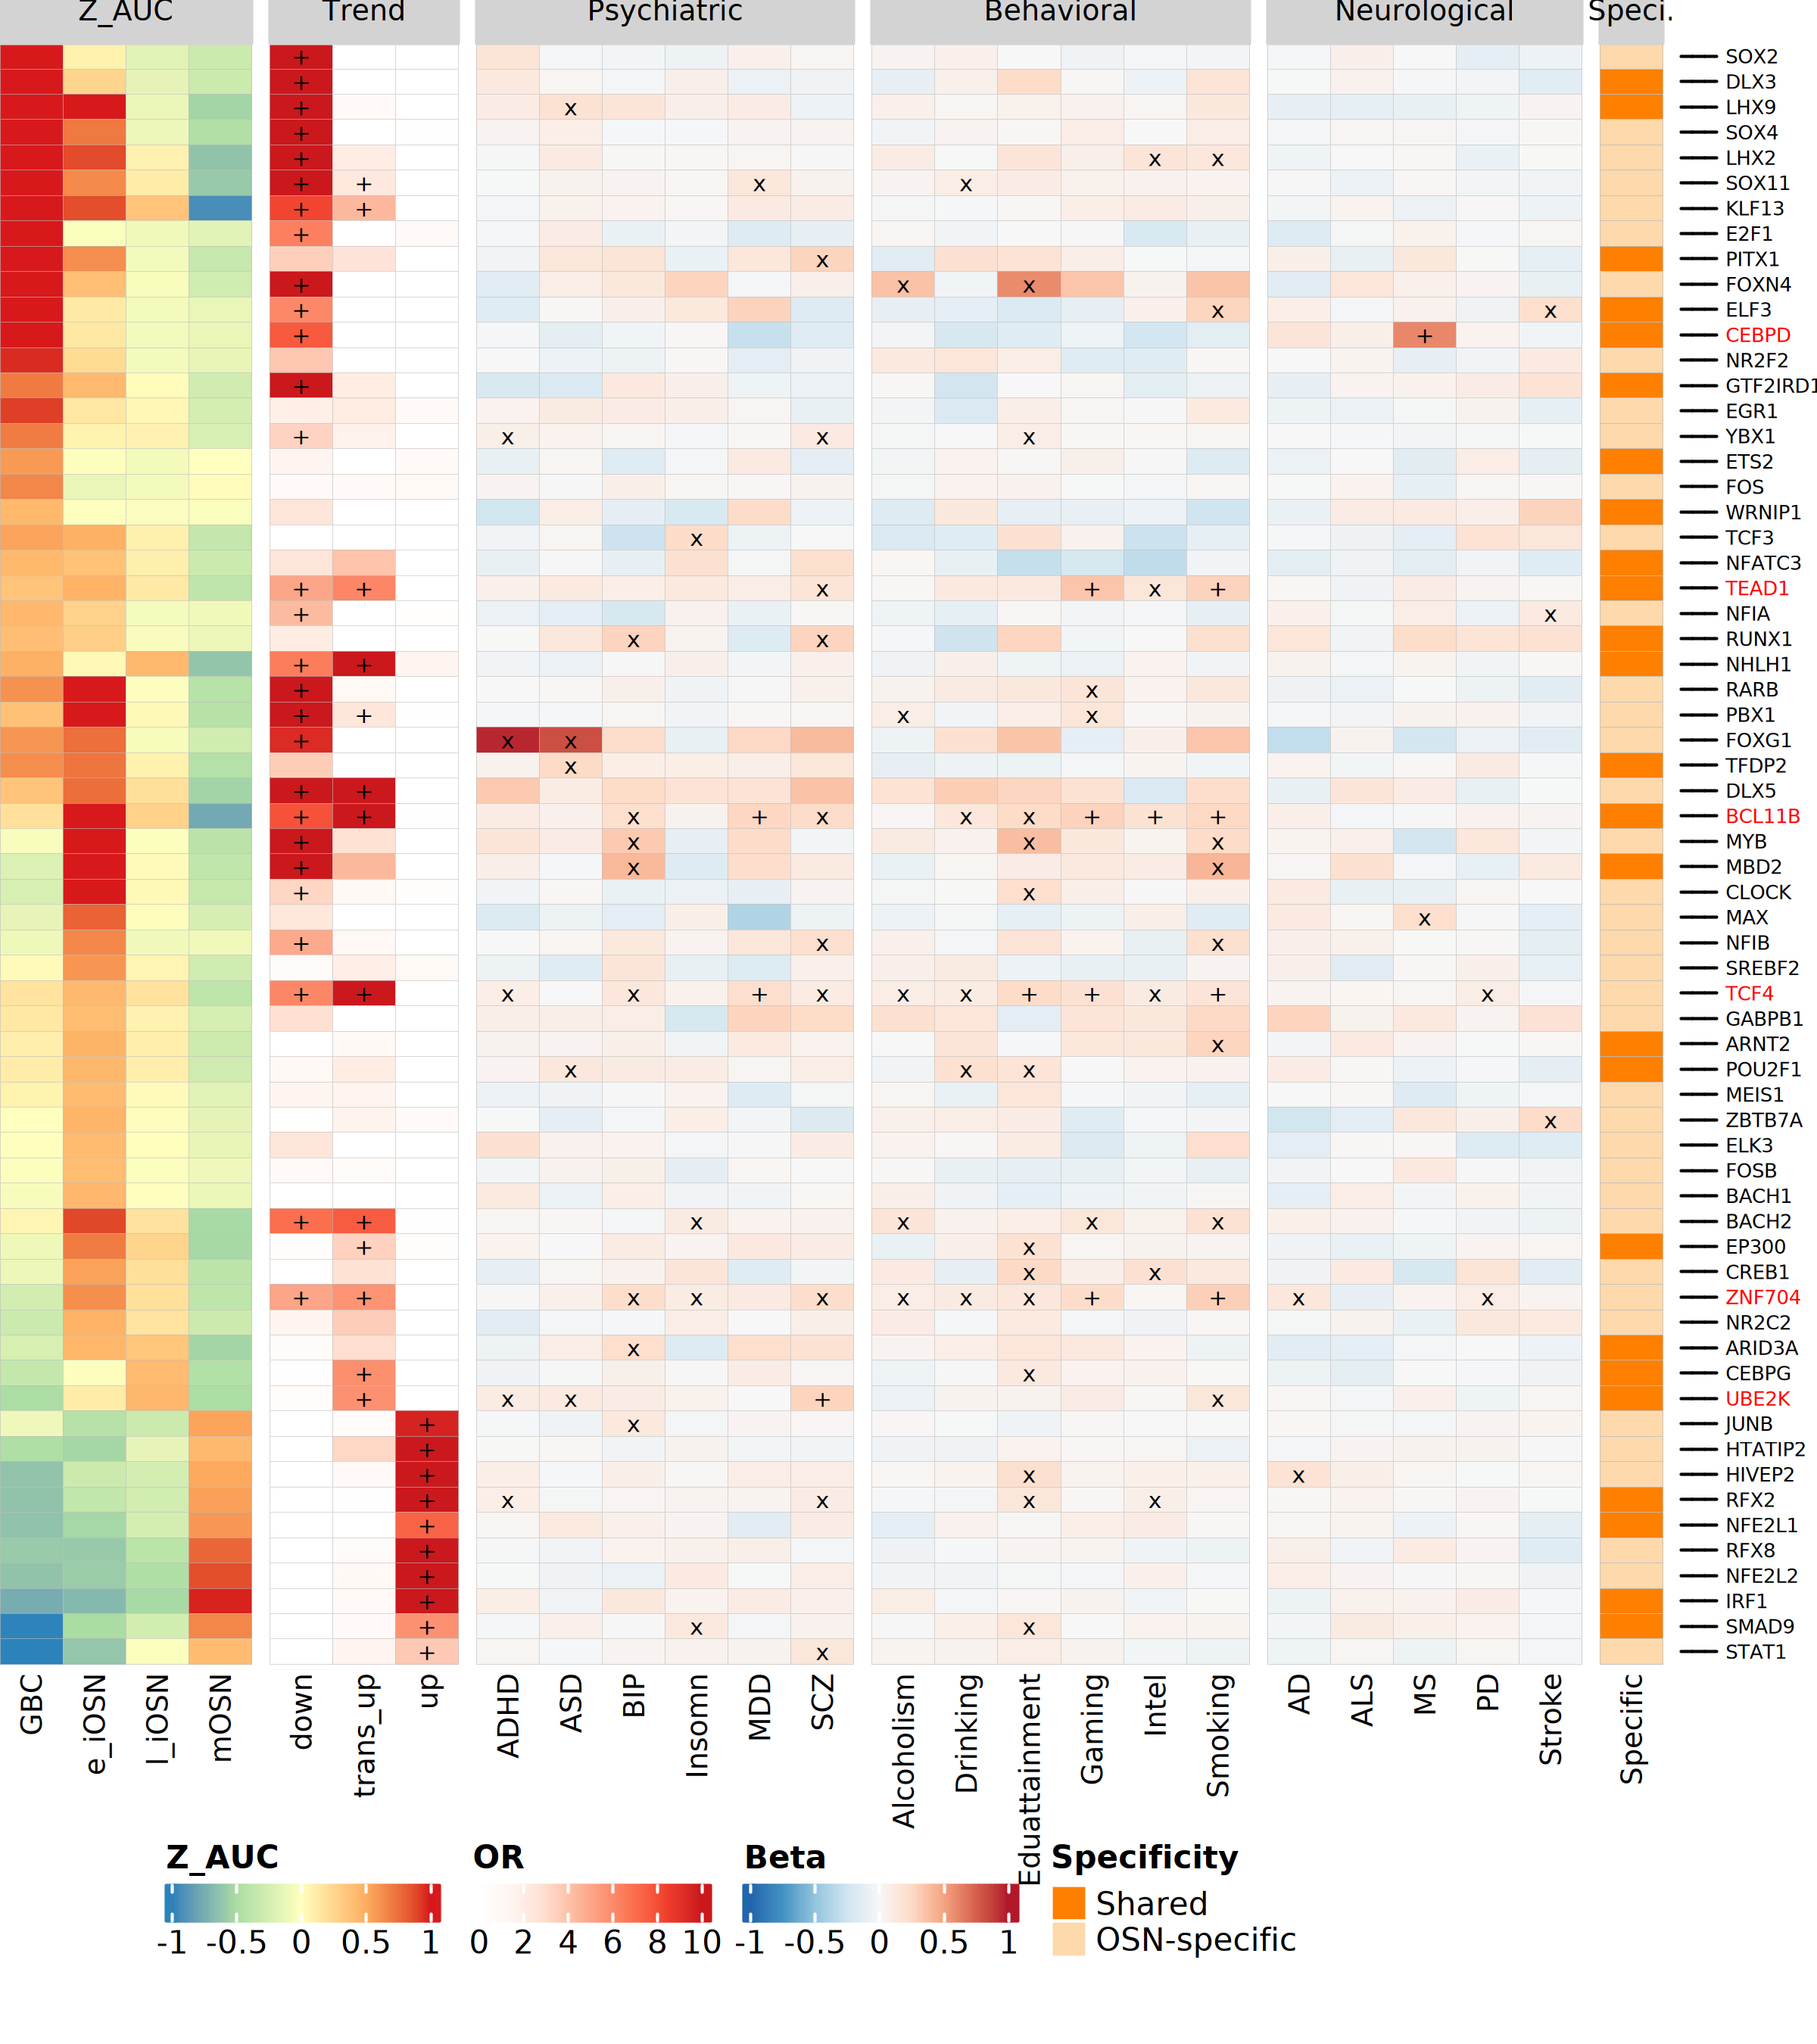

In [126]:
draw( pl_zscore+
       make_heatmap('trend')$p+
       #make_heatmap('cluster')$p+
       #make_heatmap('disease')$p+
         make_heatmap_tf("Psychiatric")$p+
         make_heatmap_tf("Behavioral")$p+
         make_heatmap_tf("Neurological")$p+
         pl_spec+
         rowAnnotation(mark = anno),
     padding=unit(c(2,0,0,0),'cm'))

draw(x = unit(0.4, "npc"), y = unit(0.07, "npc"),
     packLegend(zscore_lgd,make_heatmap('trend')$lgd,
                make_heatmap_tf("Psychiatric")$lgd,
                lgd_spec,direction = "horizontal",
                max_width = unit(20, "cm")))

dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/tf_enrich2.pdf', width=6, height=7.5)

In [120]:
dev.off()

null device 
          1


	Fisher's Exact Test for Count Data

data:  xtabs(~test + sig, zscore_tf_aucs)[c(2, 1), ]
p-value = 0.869
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.1510343       Inf
sample estimates:
odds ratio 
 0.5933359 


   OSN
sig OSN-specific Shared
  N            8     17
  Y           17     22

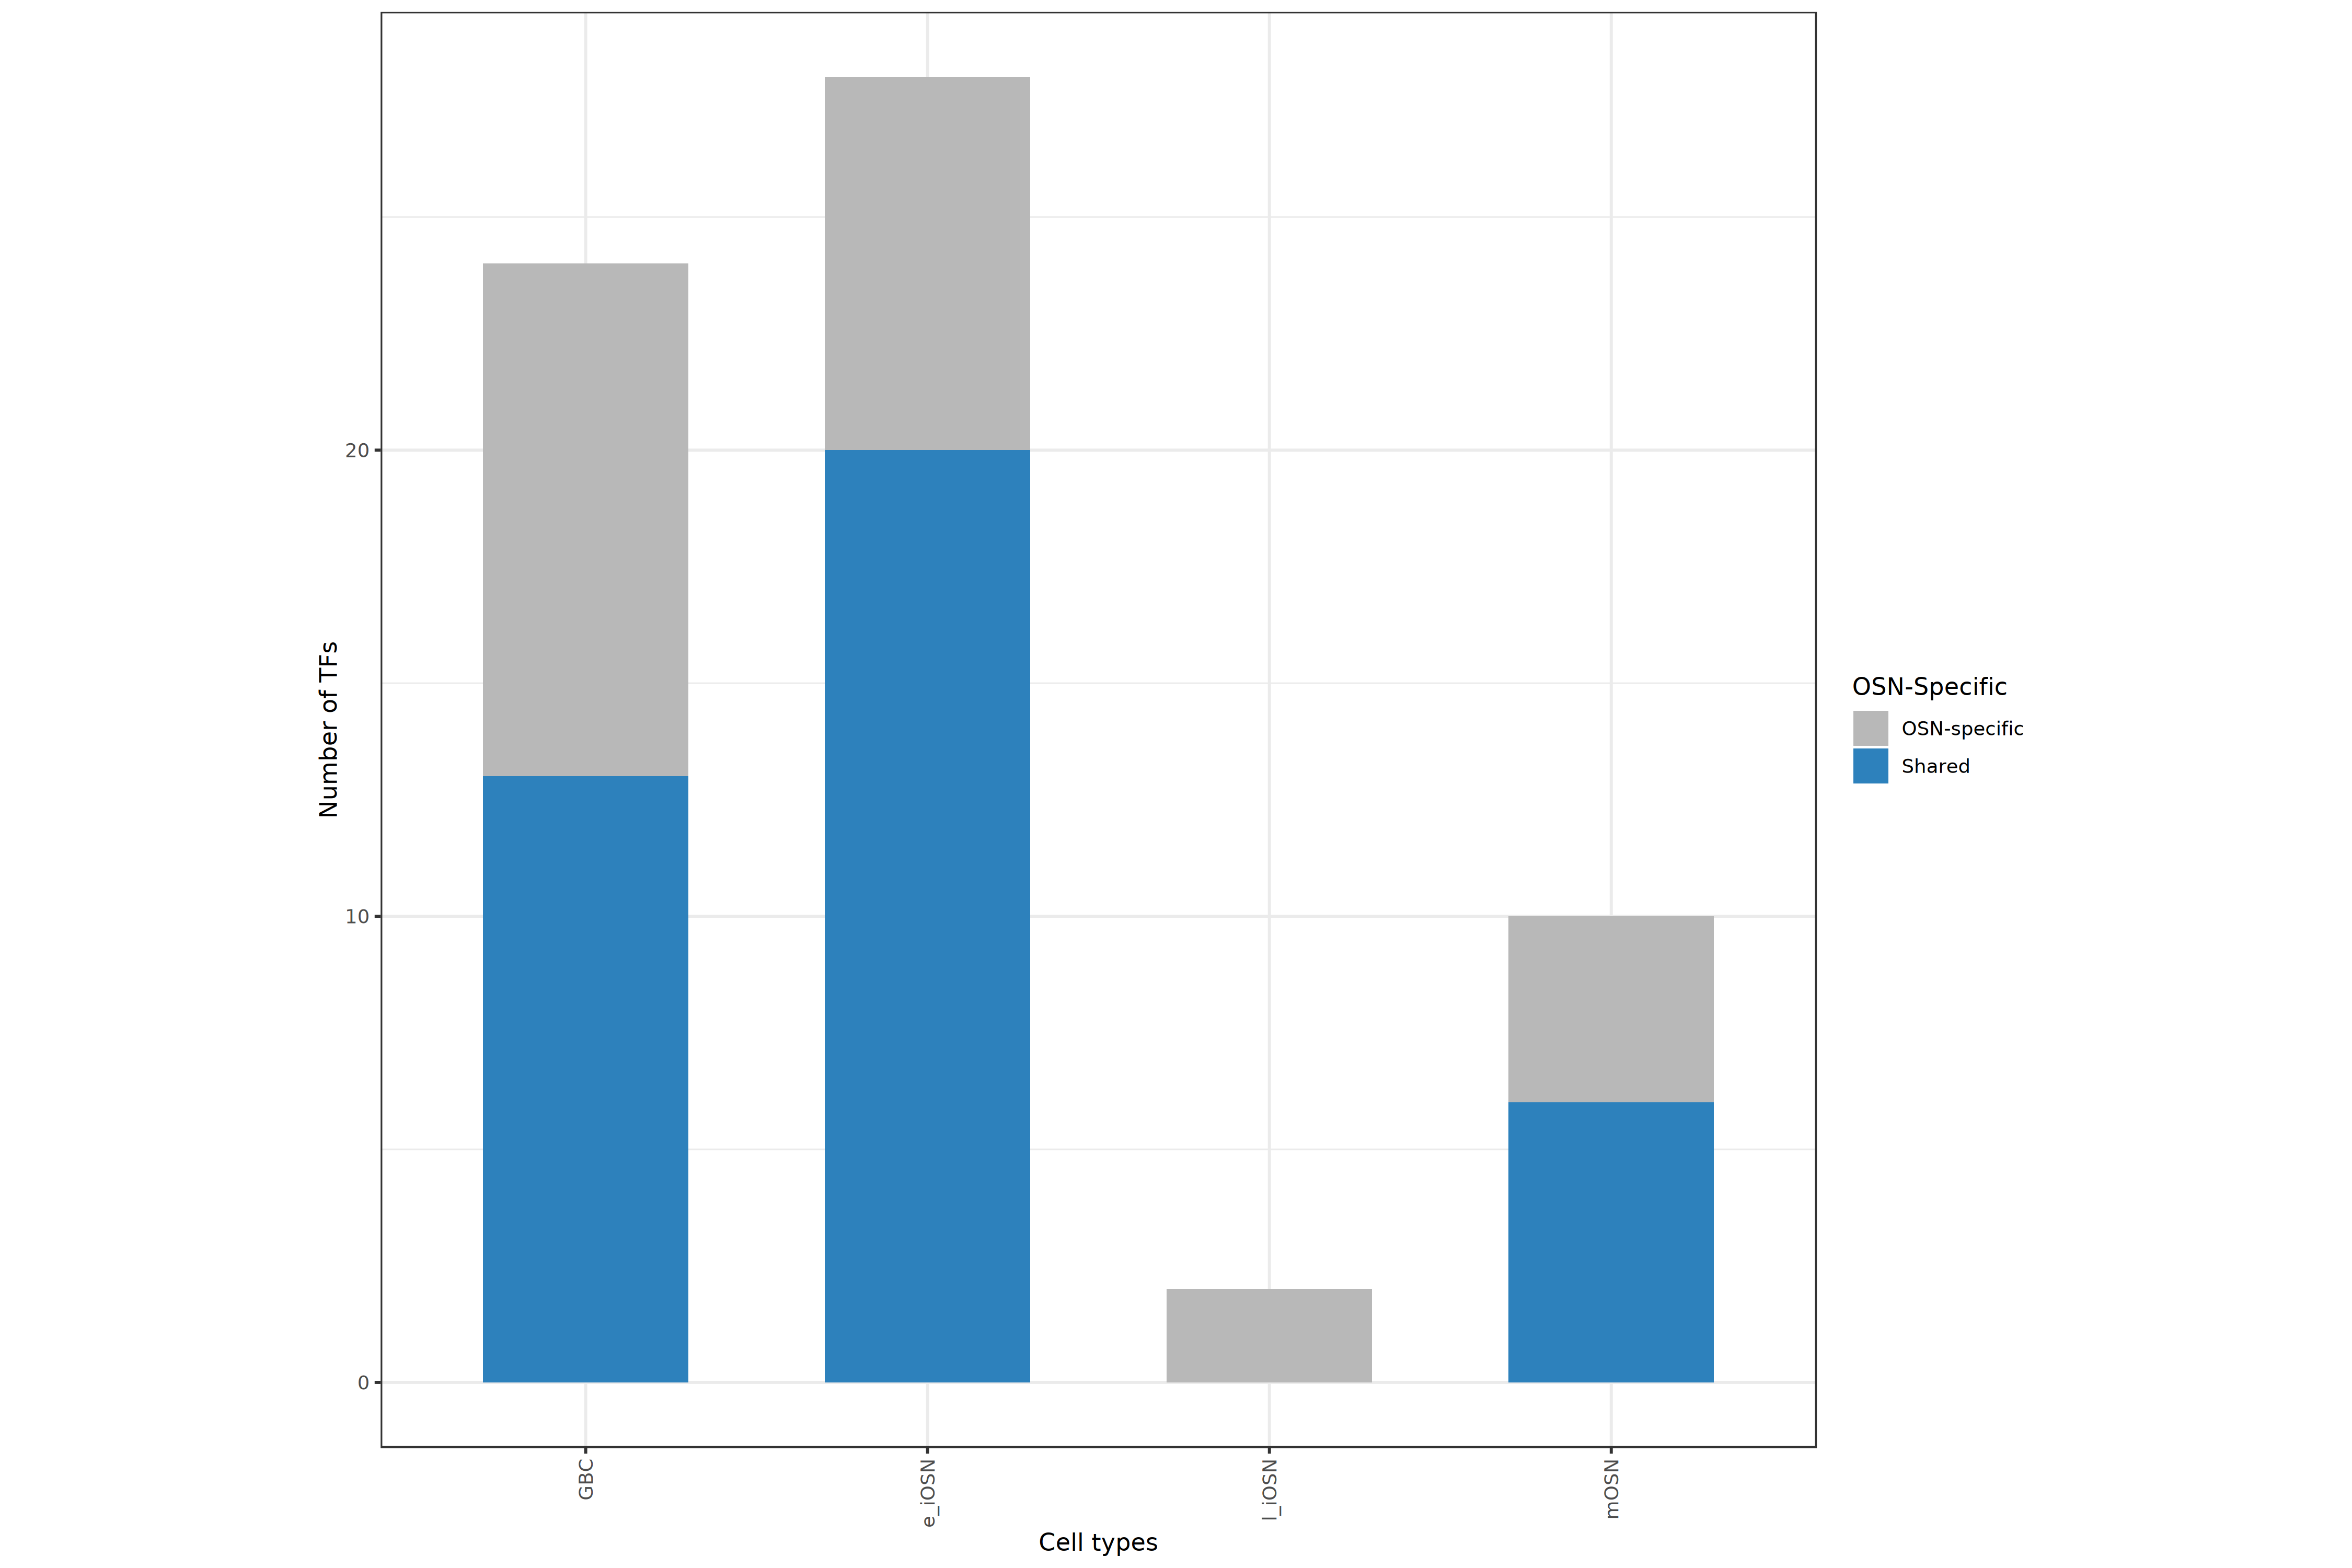

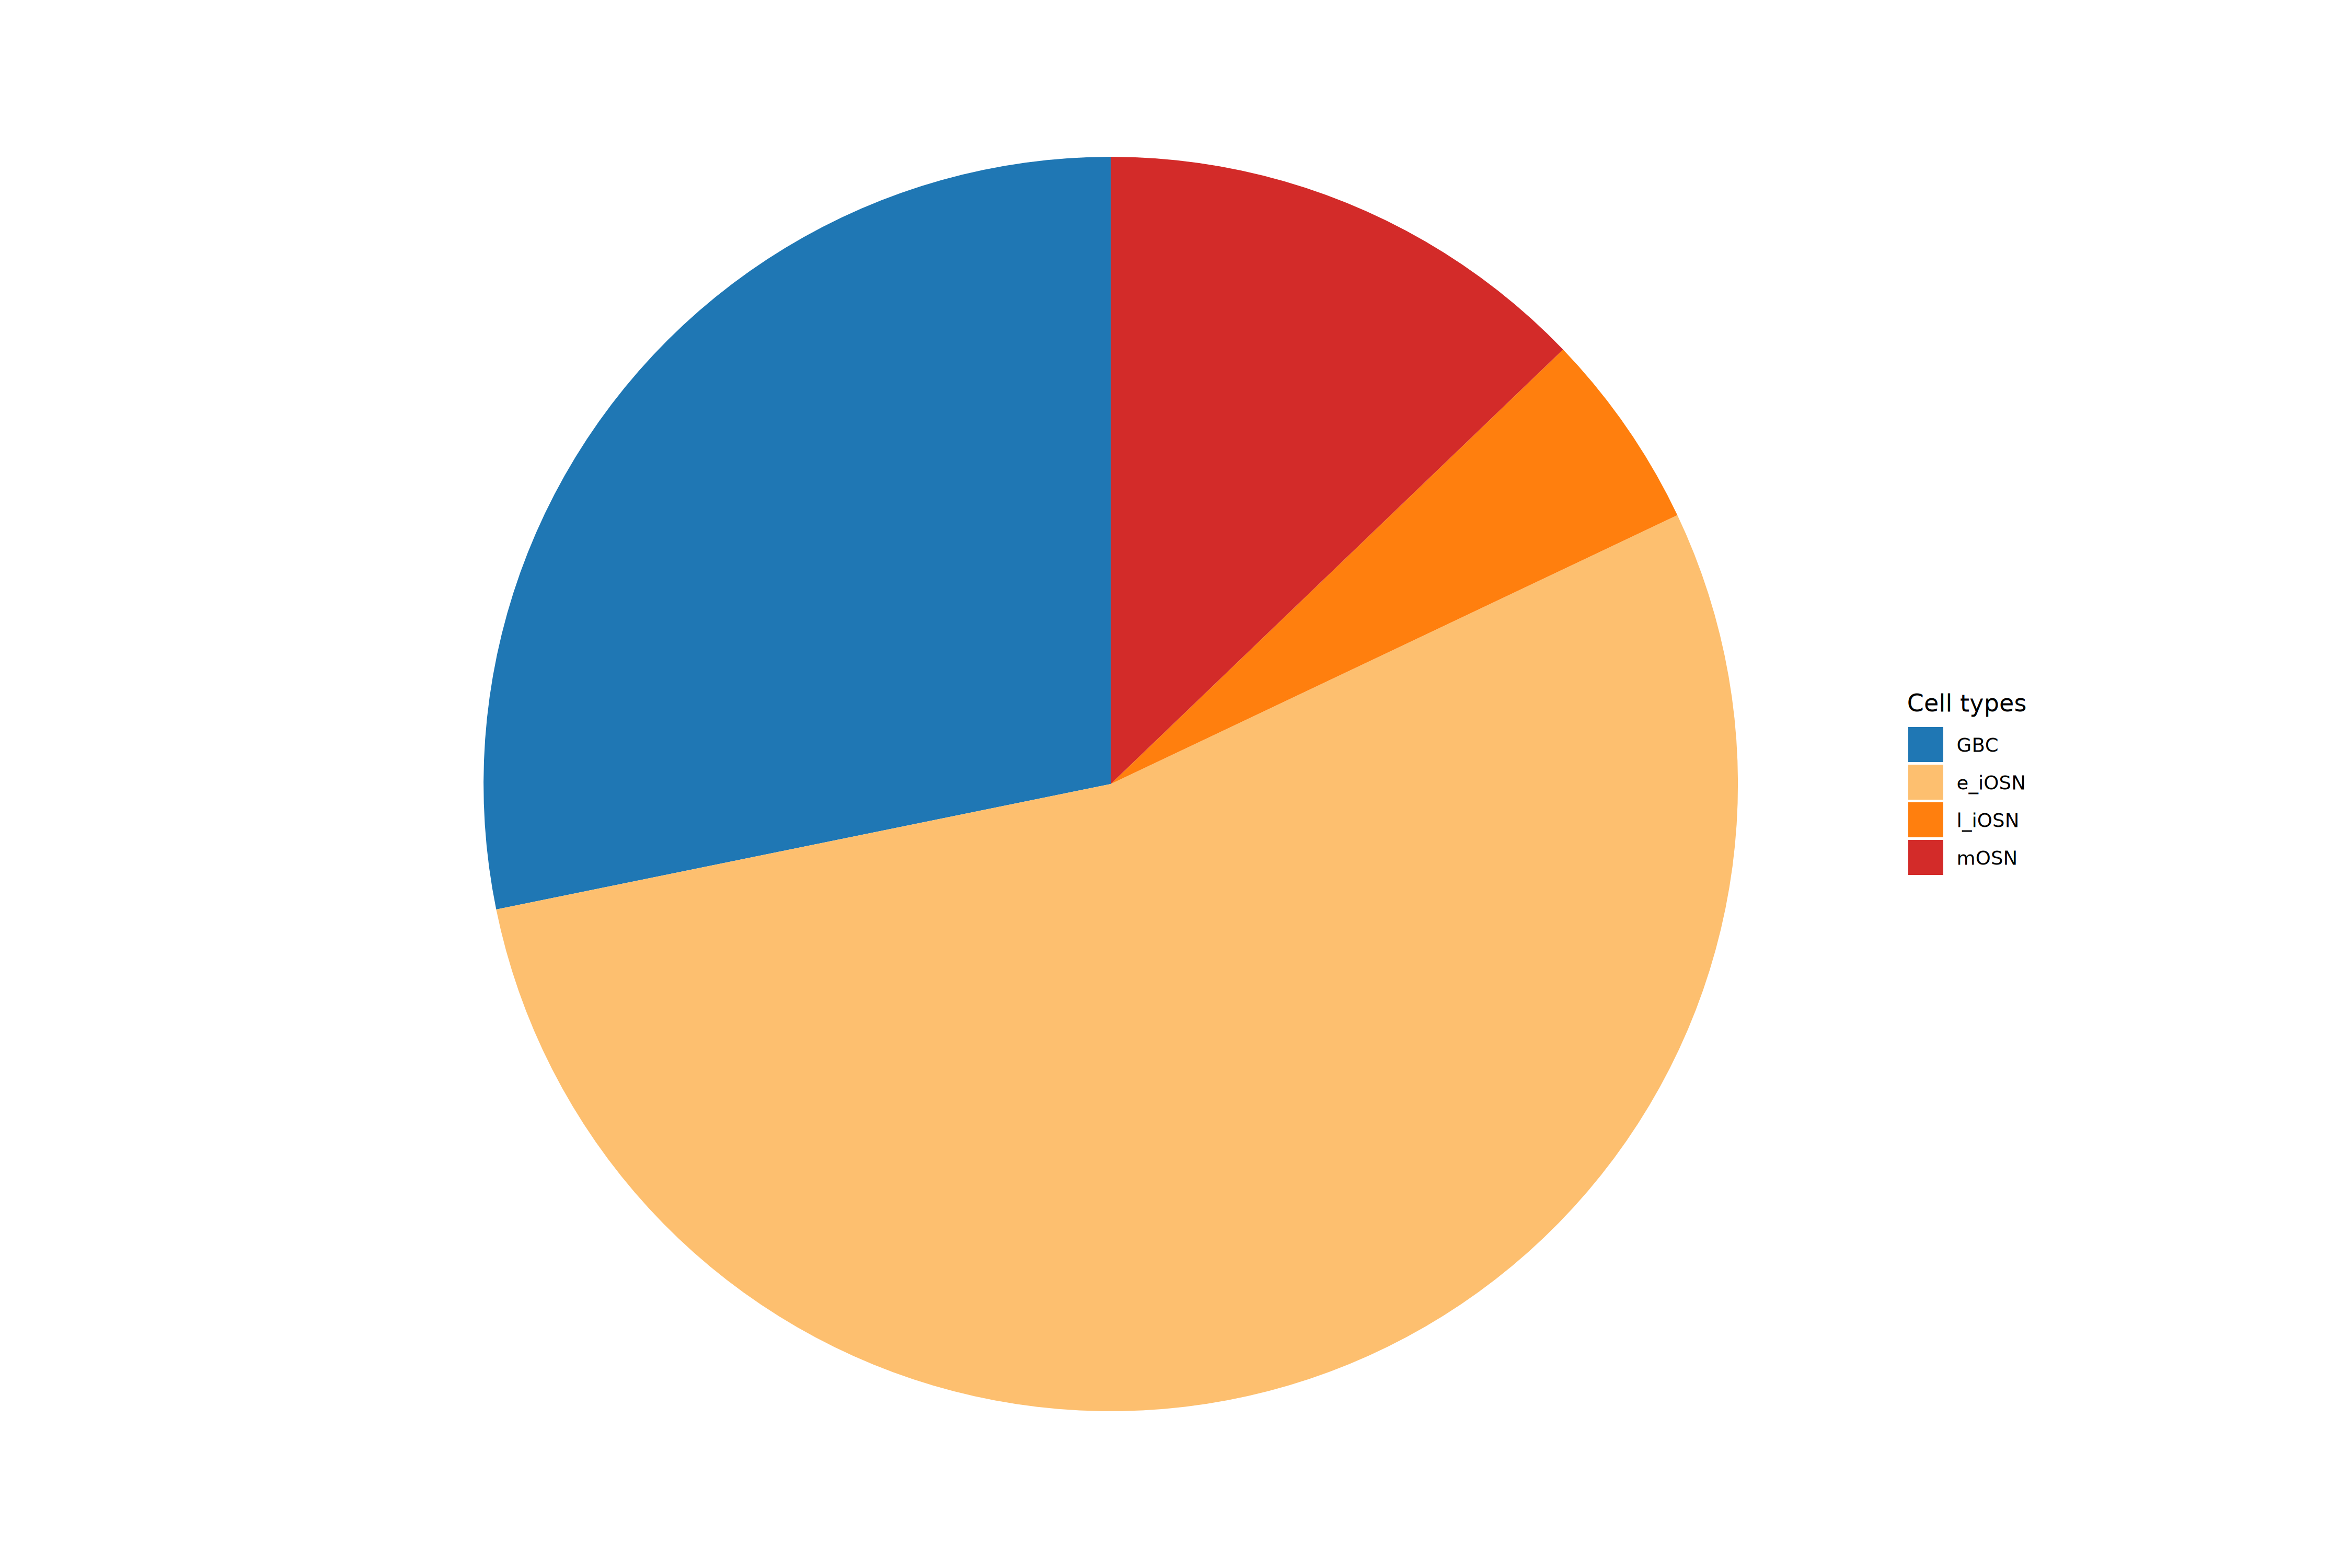

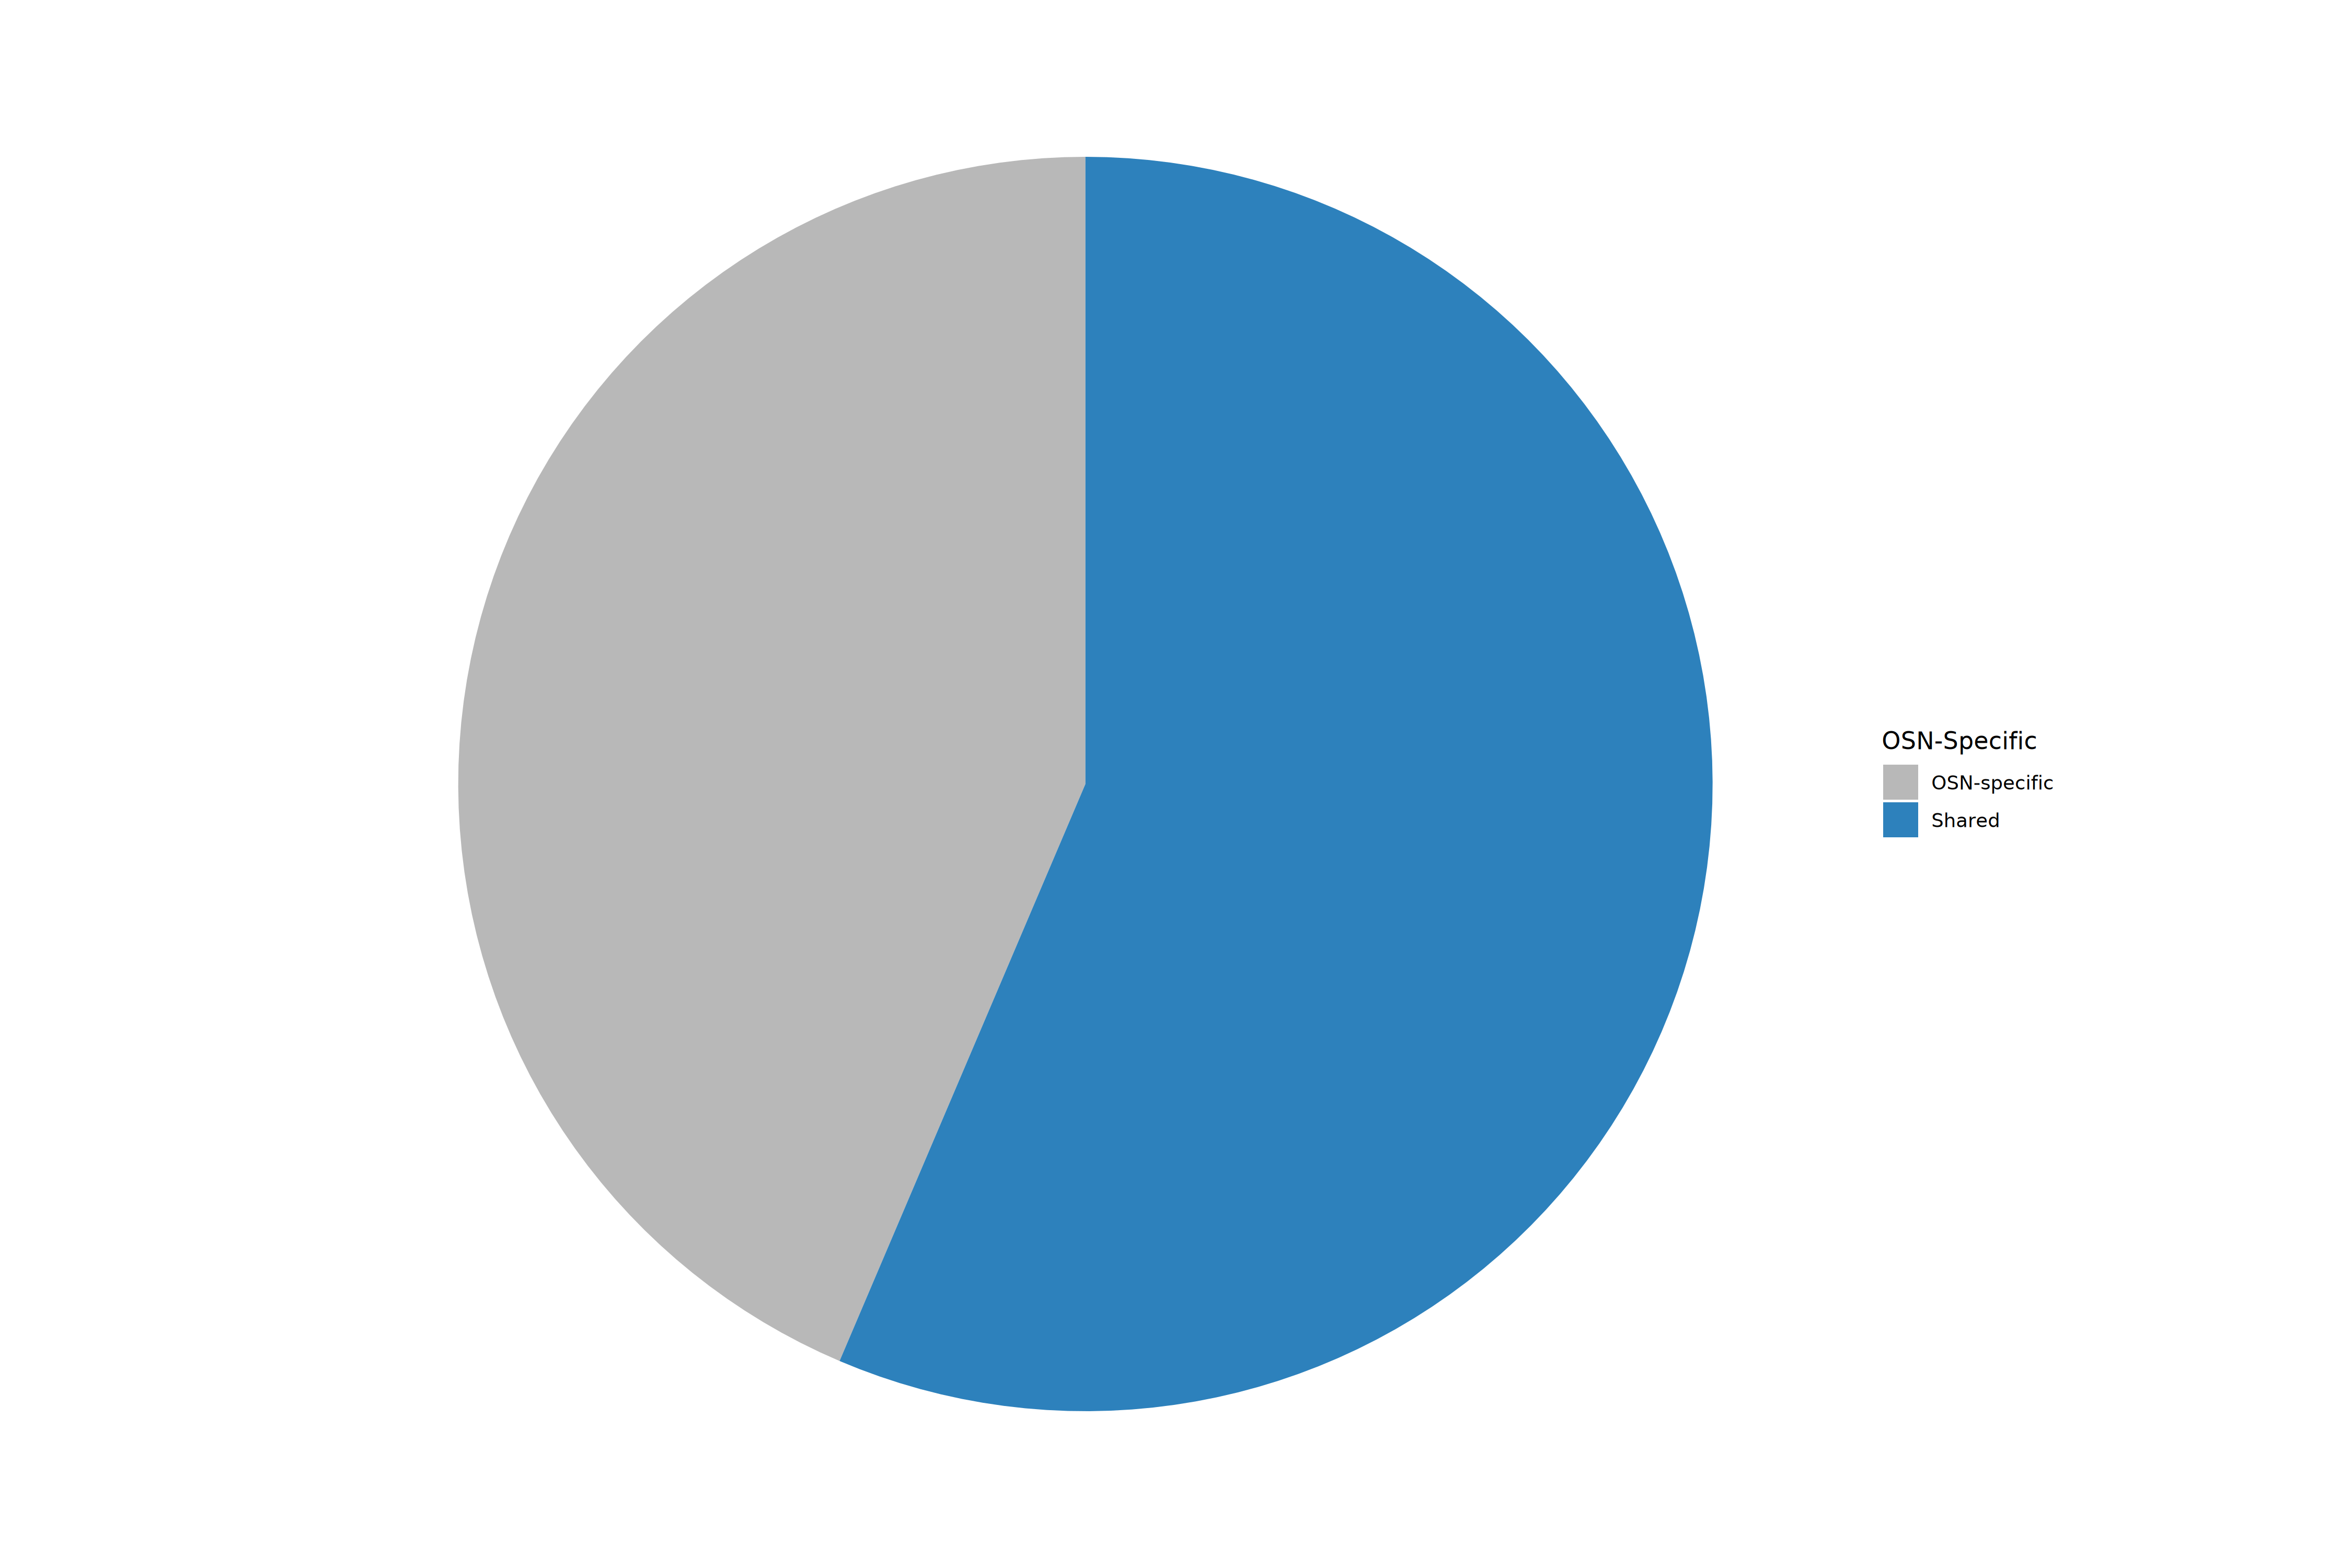

In [103]:
zscore_tf_aucs$sig <- ifelse(zscore_tf_aucs$TF%in% subset(geneSetGroupAgg_rs_sig,  P < 0.05 )[,"name"],'Y','N')#TF.sig_spec.pdf
zscore_tf_aucs$test <- ifelse(zscore_tf_aucs$maxzscore%in% c('e_iOSN','l_iOSN','GBC')  ,'Y','N')
fisher.test(xtabs(~test+sig, zscore_tf_aucs)[c(2,1),],alternative = 'greater')
xtabs(~sig+OSN, zscore_tf_aucs)


ggplot(zscore_tf_aucs, aes(x=factor(maxzscore, levels = c('GBC','e_iOSN','l_iOSN','mOSN')), fill=OSN))+
  geom_bar(position ="stack", width=0.6)+
  #geom_text(stat = "prop", position = position_stack(.5))+
  theme_bw()+
  theme(aspect.ratio = 1,axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
scale_fill_manual(values =  c('#B8B8B8','#2D81BC'))+
  labs(x='Cell types',y='Number of TFs',fill='OSN-Specific')

#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/TF.total.pdf', width=4,height=3.5)


N_stage_color <- c('#1f77b4','#FDBF6F','#ff7f0e',"#D32B29")
names(N_stage_color) <- c('GBC','e_iOSN','l_iOSN','mOSN')

ggplot(subset(zscore_tf_aucs, sig == 'Y'), aes(x=sig, fill=factor(maxzscore, levels = c('GBC','e_iOSN','l_iOSN','mOSN'))))+
  geom_bar(position = "fill")+
#geom_text(stat = "prop", position = position_stack(.5))+
  coord_polar("y", start = 0)+
  theme_void()+
  scale_fill_manual(values=N_stage_color)+labs(fill='Cell types')

#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/TF.sig_celltype.pdf', width=4.5,height=4)


ggplot(subset(zscore_tf_aucs, sig == 'Y'), aes(x=sig, fill=OSN))+
  geom_bar(position ="fill")+
#geom_text(stat = "prop", position = position_stack(.5))+
  coord_polar("y", start = 0)+
  theme_void()+labs(fill='OSN-Specific')+
scale_fill_manual(values =  c('#B8B8B8','#2D81BC'))

#dev.print(pdf, file='/sc/arion/projects/roussp01a/liting/Olf/figures/TF.sig_spec.pdf', width=4.5,height=4)


In [104]:
x <- subset(zscore_tf_aucs, sig == 'Y')
table(x$maxzscore)/nrow(x)
table(x$OSN)/nrow(x)



    e_iOSN        GBC     l_iOSN       mOSN 
0.53846154 0.28205128 0.05128205 0.12820513 


OSN-specific       Shared 
   0.4358974    0.5641026 

In [ ]:
TCF4 <- subset(sub_tf_targets_rep_s,tf%in%c('TCF4','PBX1','RFX2','WRNIP1','BCL11B'))
save(TCF4, file='/sc/arion/projects/roussp01a/liting/Olf/data/TCF4_targets.RData')


library("igraph")
library(RColorBrewer)
load('./data/TCF4_targets.RData')
TCF4 <- subset(TCF4,tf=='TCF4' & disease!='' )
g <- graph_from_data_frame(TCF4, directed=TRUE) 

trend_color <- brewer.pal(n = 8, name = "Paired")[c(1,3,5,7)]
names(trend_color) <- c('down','trans_down','up','trans_up')

TCF4$color <- trend_color[TCF4$trend_class ]
TCF4$color[is.na(TCF4$color)] <- 'grey'
V(g)$color <- c('#A6CEE3',TCF4$color)
plot(g, edge.arrow.width = 0.5)
dev.print(pdf, file='./figures/tcf4.network.pdf',width=5,height=5)







logical(0)